<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/monodep2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 4 networks: encoder and decoder for depth and pose
2. load monodepth2 parameters to test own data
3. extract frames from one SCARED video file
4. test depth esitimation on single image and pose estimation with 3 frames
5. the output suppose to axisangle -> R(4x4), translatioin -> T(4x4), R&T -> M(4x4), but still trying to get this output

#network

In [ ]:
model_url, required_md5checksum = "https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono_640x192.zip", "a964b8356e08a02d009609d9e3928f7c"
import gdown
gdown.download(model_url,'mono_640x192',quiet=True) 
import os
!unzip -q mono_640x192

replace depth.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

# Copyright Niantic 2019. Patent Pending. All rights reserved.
#
# This software is licensed under the terms of the Monodepth2 licence
# which allows for non-commercial use only, the full terms of which are made
# available in the LICENSE file.

from __future__ import absolute_import, division, print_function

import numpy as np
import torch
import torch.nn as nn

from collections import OrderedDict
import torch
from torch import nn
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()
        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out

def upsample(x):
    return F.interpolate(x, scale_factor=2, mode="nearest")

class DepthDecoder(nn.Module):
    """
    num_ch_enc:              resnet18：[64, 64, 128, 256, 512]
    scales：                 
    num_output_channels：    
    use_skips：              
    """
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips          # 
        self.upsample_mode = 'nearest'      # 
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]   # in channel
            num_ch_out = self.num_ch_dec[i]                                         # out channel
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)         # 

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)

            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs


class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """
    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def resnet_multiimage_input(num_layers, pretrained=False, num_input_images=1):
    """Constructs a ResNet model.
    Args:
        num_layers (int): Number of resnet layers. Must be 18 or 50
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        num_input_images (int): Number of frames stacked as input
    """
    assert num_layers in [18, 50], "Can only run with 18 or 50 layer resnet"
    blocks = {18: [2, 2, 2, 2], 50: [3, 4, 6, 3]}[num_layers]
    block_type = {18: models.resnet.BasicBlock, 50: models.resnet.Bottleneck}[num_layers]
    model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

    if pretrained:
        loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(num_layers)])
        loaded['conv1.weight'] = torch.cat(
            [loaded['conv1.weight']] * num_input_images, 1) / num_input_images
        model.load_state_dict(loaded)
    return model


class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers, pretrained, num_input_images=1):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):

        self.features = []
        # x = (input_image - 0.45) / 0.225
        x = input_image
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

class PoseDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_input_features, num_frames_to_predict_for=None, stride=1):
        super(PoseDecoder, self).__init__() 

        self.num_ch_enc = num_ch_enc# np.array([64,64,128,256,512])
        self.num_input_features = num_input_features# 1

        if num_frames_to_predict_for is None: #2
            num_frames_to_predict_for = num_input_features - 1
        self.num_frames_to_predict_for = num_frames_to_predict_for

        self.convs = OrderedDict()
        self.convs[("squeeze")] = nn.Conv2d(self.num_ch_enc[-1], 256, 1)
        self.convs[("pose", 0)] = nn.Conv2d(num_input_features * 256, 256, 3, stride, 1)
        self.convs[("pose", 1)] = nn.Conv2d(256, 256, 3, stride, 1)
        self.convs[("pose", 2)] = nn.Conv2d(256, 6 * num_frames_to_predict_for, 1)

        self.relu = nn.ReLU()

        self.net = nn.ModuleList(list(self.convs.values()))

    def forward(self, input_features):
        last_features = [f[-1] for f in input_features]

        cat_features = [self.relu(self.convs["squeeze"](f)) for f in last_features]
        cat_features = torch.cat(cat_features, 1)

        out = cat_features
        for i in range(3):
            out = self.convs[("pose", i)](out)
            if i != 2:
                out = self.relu(out)

        out = out.mean(3).mean(2)

        out = 0.001*out.view(-1, self.num_frames_to_predict_for, 1, 6)

        axisangle = out[..., :3]
        translation = out[..., 3:]

        return axisangle, translation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = ResnetEncoder(18, False, 1)
loaded_dict_enc = torch.load("encoder.pth", map_location=device)
feed_height, feed_width= loaded_dict_enc['height'], loaded_dict_enc['width']
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
encoder.to(device)
encoder.eval()

depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))#[ 64  64 128 256 512]
loaded_dict = torch.load("depth.pth", map_location=device)
depth_decoder.load_state_dict(loaded_dict)
depth_decoder.to(device)
depth_decoder.eval()

pose_encoder = ResnetEncoder(18, "pretrained", 2)
loaded_dict = torch.load("pose_encoder.pth", map_location=device)
pose_encoder.load_state_dict(loaded_dict)
pose_encoder.to(device)
pose_encoder.eval()

pose_decoder = PoseDecoder(encoder.num_ch_enc,1,2)#num_input_features, num_frames_to_predict_for
loaded_dict = torch.load("pose.pth", map_location=device)
pose_decoder.load_state_dict(loaded_dict)
pose_decoder.to(device)
pose_decoder.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


PoseDecoder(
  (relu): ReLU()
  (net): ModuleList(
    (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

#arguments

In [ ]:
import argparse
import sys

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=120, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')
    parser.add_argument('--image_path', type=str, default='d3k1_video', help='path')
    parser.add_argument('--frame_ids', type=str, default=[0,-1,1], help='path') #when stereo mode [0,'s'] 
    parser.add_argument('--scale', type=str, default=[0,1,2,3], help='path') #when stereo mode [0,'s'] 
    parser.add_argument('--K', type=str, default= np.array([[0.82, 0, 0.5, 0],
                                                            [0, 1.02, 0.5, 0],
                                                            [0,    0,   1, 0],
                                                            [0,    0,   0, 1]], dtype=np.float32), help='path') #when stereo mode [0,'s'] 

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

args = get_args()

#data

In [ ]:
import gdown
gdown.download('d3k1_video', 'https://drive.google.com/uc?id=17k1-CHptG_XTXVX8qp7yK_zadH54vVnY', quiet=True) 

'd3k1_video'

In [ ]:
import glob

if os.path.isfile(args.image_path):
    paths = [args.image_path]
    output_directory = os.path.dirname(args.image_path)
elif os.path.isdir(args.image_path):
    paths = glob.glob(os.path.join(args.image_path, '*.{}'.format(args.ext)))
    output_directory = args.image_path
print(paths)

['d3k1_video']


In [ ]:
#@title video to frame

import os
import cv2  

def video2frames(pathIn='',
                 pathOut='',
                 only_output_video_info=False,
                 initial_extract_time=0,
                 end_extract_time=None,
                 extract_time_interval=-1,# default all, skip frames between time gap
                 output_prefix='frame',
                 jpg_quality=100,#0~100
                 isColor=True):

    cap = cv2.VideoCapture(pathIn) 
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
    fps = cap.get(cv2.CAP_PROP_FPS) 
    dur = n_frames / fps  
    if only_output_video_info:# only info
        print("\nDuration of the video: {} seconds".format(dur),"\nNumber of frames: {}".format(n_frames),"\nFrames per second (FPS): {}".format(fps))

    else:# 

        if extract_time_interval == -1:# all frames in interval
                success = True
                count = 0
                while success:
                    success, image = cap.read()
                    if success:
                        if not isColor:
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        print('Write a new frame: {}, {}/{}'.format(success, count + 1, n_frames))
                        cv2.imwrite(os.path.join(pathOut, "{}_{:03d}.jpg".format(output_prefix,count + 1)), image,#all frames
                                    [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]) 
                        count = count + 1     
        elif extract_time_interval > 0 and extract_time_interval < 1 / fps:
            raise NameError('extract_time_interval is less than the frame time interval....')
        elif extract_time_interval > (n_frames / fps):
            raise NameError('extract_time_interval is larger than the duration of the video....')
       
        else:## skip some frames during time gap
            try:
                os.mkdir(pathOut)
            except OSError:
                pass
            success = True
            count = 0
            while success:
                cap.set(cv2.CAP_PROP_POS_MSEC, (1000 * initial_extract_time + count * 1000 * extract_time_interval))
                success, image = cap.read()
                if success:
                    if not isColor:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    #print('Write a new frame3: {}, {}th'.format(success, count + 1))
                    cv2.imwrite(os.path.join(pathOut, "{}_{:03d}.jpg".format(output_prefix, count + 1)), image,
                                [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]) 
                    count = count + 1




Duration of the video: 13.16 seconds 
Number of frames: 329 
Frames per second (FPS): 25.0
9


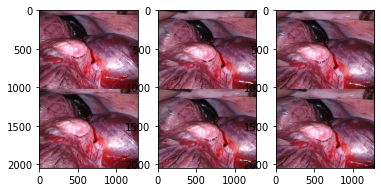

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import math

pathIn = '/content/d3k1_video'
video2frames(pathIn, only_output_video_info=True)
pathOut = '/content/d3k1_frames/'
video2frames(pathIn, pathOut,output_prefix='d3k1',extract_time_interval=2)

path_frame_all = glob('d3k1_frames/*.jpg')
print(len(path_frame_all))

for i in range(3):
  plt.subplot(131+i), plt.imshow(plt.imread("d3k1_frames/d3k1_00{}.jpg".format(1+i)))

In [141]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
# An item of dataset is a dictioinary. Keys in the dictionary are either strings or tuples:
#             ("color", <frame_id>, <scale>)          for raw colour images,
#             ("color_aug", <frame_id>, <scale>)      for augmented colour images,
#             ("K", scale) or ("inv_K", scale)        for camera intrinsics, 
#             "stereo_T"                              for camera extrinsics, for stereo, and
#             "depth_gt"                              for ground truth
#scale:  -1      images at native resolution as loaded from disk  (1280,1024) (1280,2048)
       # 0       images resized to (self.width,      self.height     )  (256,320) (640,192)
       # 1       images resized to (self.width // 2, self.height // 2)
       # 2       images resized to (self.width // 4, self.height // 4)
       # 3       images resized to (self.width // 8, self.height // 8)
transform_all = transforms.Compose([
    transforms.Resize((256, 320)),#((640,192)),
    transforms.ToTensor(),
])
inputs = {}
for i,ids in enumerate(args.frame_ids):
  inputs[("color_aug",ids,0)] = transform_all(pil_loader("d3k1_frames/d3k1_00{}.jpg".format(1+i)))
print(inputs.keys())
     


#inputs[("color",i,-1)] = get_color(folder, frame_index, other_side, do_flip)
#for i in args.frame_ids:
  #inputs[("color",i,-1)] = get_color(folder, frame_index+1, side, do_flip)
#inputs[("K",scale)] = torch.from_numpy(args.K)
#inputs[("inv_K",scale)] = torch.from_numpy(inv_K)
#inputs["stereo_T"] = torch.from_numpy(stereo_T)

#line = self.filenames[index].split() #the index th row
#frame_index = int(line[1]) #line has 3 parts, the second is frame_id 0 or -1 or 1
# side = line[2] #the third is l/r 
# folder = line[0] # the first part is folder name
# self.preprocess(inputs, color_aug)
# for i in args.frame_idxs:
#     del inputs[("color", i, -1)]
#     del inputs[("color_aug", i, -1)]

dict_keys([('color_aug', 0, 0), ('color_aug', -1, 0), ('color_aug', 1, 0)])


#test

In [140]:
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib as mpl
import matplotlib.cm as cm


capture = cv2.VideoCapture("d3k1_video")
#while 1:
ret, frame = capture.read()#c = cv2.waitKey(1) & 0xff
#with torch.no_grad():
    #for idx, image_path in enumerate(paths):
        # if image_path.endswith("_disp.jpg"):             
        #     continue# don't try to predict disparity for a disparity image!  
input_image = Image.fromarray(np.uint8(frame))
original_width, original_height = input_image.size# 1280 2048
input_image = input_image.transpose(Image.ROTATE_90) # (2048 1024)
input_image = input_image.resize((feed_width, feed_height), Image.LANCZOS)#640 192
input_image = transforms.ToTensor()(input_image).unsqueeze(0)

input_image = input_image.to(device)
features = encoder(input_image)#
outputs = depth_decoder(features)#

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(
    disp, (original_height, original_width), mode="bilinear", align_corners=False)
# output_name = os.path.splitext(os.path.basename(image_path))[0] #('d3k1_video', '')[0]='d3k1_video'
min_disp = 1 / 100 # max_depth=100 #diap_to_depth
max_disp = 1 / 0.1 # min_depth=0.1
scaled_disp = min_disp + (max_disp - min_disp) * disp
# name_dest_npy = os.path.join(output_directory, "{}_disp.npy".format(output_name))
# np.save(name_dest_npy, scaled_disp.cpu().numpy())
disp_resized_np = disp_resized.squeeze().detach().numpy()
vmax = np.percentile(disp_resized_np, 95)

normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
im = Image.fromarray(colormapped_im)
# name_dest_im = os.path.join(output_directory, "{:03d}.jpeg".format(i))
# colormapped_im = cv2.cvtColor(colormapped_im, cv2.COLOR_BGR2RGB)

##pose

The pose encoder is modified to accept a pair of frames, or **six channels**, as input. It has has convolutional weights in the first layer of shape 6×64×3×3, instead of the **ResNet** default of 3×64×3×3. The first pre-trained filter tensor needs to be **duplicated along the channel dimension**.

The Pose decoder module is a fully convolutional network and it predicts the rotation using an axis-angle representation and **scale the rotation and translation** outputs by 0.01.

In [139]:
def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot

def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T

def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M

#def predict_poses(inputs, features, disps):
"""Predict poses between input frames for monocular sequences.
"""
outputs = {}
pose_feats = {f_i: inputs[("color_aug", f_i, 0)] for f_i in args.frame_ids}
print(pose_feats.keys())
print(pose_feats[0].shape)    
print( torch.cat([pose_feats[0],pose_feats[1]],0).shape )

for f_i in args.frame_ids[1:]: #[-1,1]
 
    if f_i < 0:#temporal order
        pose_inputs = [pose_feats[f_i], pose_feats[0]]
    else:
        pose_inputs = [pose_feats[0], pose_feats[f_i]]

    pose_inputs = [pose_encoder(torch.cat(pose_inputs, 1))]
    axisangle, translation = pose_decoder(pose_inputs)
    outputs[("axisangle", 0, f_i)] = axisangle
    outputs[("translation", 0, f_i)] = translation
    outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
        axisangle[:, 0], translation[:, 0])  #axisangle -> R(4x4), translatioin -> T(4x4), R&T -> M(4x4)
print(outputs)

dict_keys([0, -1, 1])
torch.Size([3, 640, 192])
torch.Size([6, 640, 192])


RuntimeError: ignored